# Michelin survivor
Michelin-rated restaurants are some of the highest-grossing businesses in the fine-dining industry – a $10 billion market in the U.S. Inversely, losing a Michelin star can make a business less profitable, with up to 40% of these businesses closing within 5 years. At Insight, I used Yelp reviews to develop a product that forecasts the risk of a restaurant losing a Michelin star and provides actionable insights to restaurateurs and investors on how to improve if their business is deemed at risk. Restaurants have vastly different timelines - from opening, getting Michelin-rated, to closing shop - so wrangling 100k Yelp reviews into usable time-series was a significant challenge to overcome, and vital in broader risk assessment and survival analysis problems.

In [1]:
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd


michelin_data    = pd.read_csv('michelin_nyc_stars.csv')
michelin_data    = michelin_data.iloc[:,1:]

michelin_data['name'] = michelin_data['name'].replace(to_replace = {'breslin': 'the-breslin',
                           'cho-dang-gol': 'cho-dang-gol-korean-restaurant',
                            'el-parador': 'el-parador-cafe',
                            'ginza-onodera': 'sushi-ginza-onodera',
                            'good-fork': 'the-good-fork',
                            'grammercy-tavern': 'gramercy-tavern',
                                                   'great-ny-noodletown': 'great-ny-noodle-town',
                                                    'katzs': 'katzs-delicatessen',
                                                    'kurumazushi': 'kuruma-zushi',
                                                  'modern' : 'the-modern',
                                                   'modern,-the': 'the-modern',
                                                  'sevilla': 'sevilla-restaurant',
                                                   'spotted-pig' : 'the-spotted-pig'})

michelin_data['name'] = (michelin_data['name'].str.replace('é', 'e').str.replace('ë', 'e').str.replace('ü', 'u'))
michelin_data         = michelin_data.drop_duplicates(keep = 'first')
michelin_data         = michelin_data.drop([216,217], axis = 0)

dupes = michelin_data.name[michelin_data.name.duplicated()]
dupes = michelin_data.loc[michelin_data.name.duplicated(keep = False)].sort_values(by = 'name')

# for each in dupes
# dupes.loc[dupes.name == 'cafe'] = dupes.iloc[0,:] + dupes.iloc[1,:]
# for each in dupes.name.unique():

new = pd.DataFrame(columns = dupes.columns)
i = 0
for each in dupes.name.unique():
    new.loc[i] = dupes.loc[(dupes.name==each)].sum(axis = 0, numeric_only = True)
    i+=1
new['name'] = dupes.name.unique()

michelin_data = michelin_data.drop(dupes.index, axis = 0)
michelin_data = pd.concat([michelin_data,new], axis = 0).reset_index(drop = True)
michelin_data['name'] = (michelin_data['name'].str.replace('gunter-seeger-ny', 'gunter-seeger'))
michelin_data.name.unique()

array(['15-east', 'a-voce', 'a-voce-columbus', 'adour', 'agern',
       'ai-fiori', 'aldea', 'allen-and-delancey', 'alto', 'amy-ruths',
       'andanada', 'annisa', 'anthos', 'aquavit', 'aska', 'atera',
       'atomix', 'aureole', 'babbo', 'baci-and-abbracci', 'bar-uchū',
       'belleville', 'betony', 'beyoglu', 'bianca', 'bib-gourmand',
       'blanca', 'blue-hill', 'blue-ribbon-bakery', 'blue-smoke',
       'bouley', 'bouley-at-home', 'brushstroke', 'bâtard', 'cafe-gray',
       'cagen', 'carbone', 'casa-enrique', 'casa-mono', 'caviar-russe',
       'chefs-table-at-brooklyn-fare', 'cho-dang-gol-korean-restaurant',
       'claro', 'congee-village', 'contra', 'convivio', 'corton', 'cote',
       'country', 'country-restaurant', 'craft', 'cru', 'daisy-mays-bbq',
       'daniel', 'danji', 'danny-brown-wine-bar-and-kitchen', 'danube',
       'del-posto', 'delaware-and-hudson', 'dinosaur-bar-b-que',
       'dovetail', 'dressler', 'devi', 'eighty-one', 'el-parador-cafe',
       'eleven-mad

## Data preprocessing and helper functions

In [27]:
# %load helper_functions.py
import numpy as np
from scipy.stats import linregress, kurtosis, skew
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from sklearn import preprocessing
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize




def get_review_topic_weights():
    new_data  = pd.read_csv('yelp_data_additional.csv', header = None, names = ['restaurant', 'date', 'rating', 'review'])
    old_data  = pd.read_csv('michelin_yelp_reviews.csv')

    yelp_data = pd.concat([new_data, old_data], axis = 0)
    yelp_data['restaurant'] = (yelp_data['restaurant'].str.replace('é', 'e').str.replace('ë', 'e')
                               .str.replace('ū', 'u').str.replace('ü', 'u').str.replace('gunter-seeger-ny', 'gunter-seeger')
                              )

    yelp_data = yelp_data.drop_duplicates(keep = 'first')

    yelp_data['review'] = (yelp_data.review.str.replace('\\\\xc2', '')
                           .str.replace('\\\\xa0', '')
                            .str.replace('\\\xa0', '')
                           .str.lower()
                           .str.replace('\d+', '')
                           .str.replace(r'[^\w\s]+', '')
                            .str.replace('cocktails', 'cocktail')
                            .str.replace('zzs', '')
                            .str.replace('xc', '')
                            .str.replace('xa', '')
                            .str.replace('zz', '')
                            .str.replace('       ', '')
                            .str.replace('eellent', 'excellent')
                            .str.replace(r'\bthe\b', '')
                            .str.replace(r'\band\b', '')
                            .str.replace(r'\bas\b', '')
                            .str.replace(r'\bof\b', '') )

    yelp_data['date']   = pd.to_datetime(yelp_data.date.str.replace('Updatedreview', ''))
    
    yelp_df   = yelp_data.copy().reset_index(drop = True)
    
    extra_words = ['ve', 'like', 'got', 'just',
                       'don', 'really', 'said', 'told', 'ok',
                       'came', 'went', 'did', 'didn', 'good', 'momofuku', 'peter', 'luger' ,'lugers',
                  'katzs']

    stop_words = text.ENGLISH_STOP_WORDS.union(extra_words)
    tfidf      = TfidfVectorizer(stop_words=stop_words, min_df=10, max_df=0.5,
                                ngram_range=(1,1), token_pattern='[a-z][a-z]+')
    dicty = {'noodles' : 'noodle', 'dishes': 'dish',
                 'buns': 'bun', 'asked' : 'ask',
                 'pieces' :'piece', 'burgers' : 'burger' ,
                'minutes' : 'minute', 'orders' : 'order', 'waffles' :'waffle'}

    def replace_words(text, dicty):
            for i,j in dicty.items():
                text = text.replace(i,j)
            return text

    reviews_processed   = [replace_words(w, dicty) for w in yelp_data.review]
    review_vectors      = tfidf.fit_transform(reviews_processed )
    num_topics          = 10
    nmf_reviews         = NMF(n_components=num_topics)
    topic_weights       = nmf_reviews.fit_transform(review_vectors)
    no_topics = num_topics
    no_top_words = 6

    def display_topics(model, feature_names, num_topics, no_top_words):
        for topic_idx, topic in enumerate(model.components_):
            if topic_idx < num_topics:
                print("{:11}".format("Topic %d:" %(topic_idx)), end='')
                print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                                 for i in topic.argsort()[:-no_top_words-1:-1]]))

    print('Top topics + words for all reviews')
    print('-'*39)
    display_topics(nmf_reviews, tfidf.get_feature_names(), no_topics, no_top_words)



    topics = {0:'wait time', 1:'food1', 2:'food2',
                          3:'food3', 4:'service', 5: 'food4',
                          6: 'food5', 7: 'food6', 8: 'menu', 9: 'value'}


    new_topics = ['wait time', 'menu', 'food_quality', 'service', 'value']


    topic_weights_df = pd.DataFrame(normalize(topic_weights, norm='l1'), columns = list(topics.values()))

    topic_weights_df['menu']         =   topic_weights_df['menu']
    topic_weights_df['food_quality'] = (topic_weights_df['food1'] + topic_weights_df['food2']
                                    + topic_weights_df['food3'] +  topic_weights_df['food4'] + topic_weights_df['food5']
                                        +topic_weights_df['food6'])/3
    # topic_weights_df.loc[yelp_data.rating <= 3][new_topics] = -1* topic_weights_df.loc[yelp_data.rating <= 3][new_topics]


    def threshold(number):
            if abs(number) > .25:
                return(int(1)) * np.sign(number)
            else:
                return(int(0))
    neg_ind = yelp_df.loc[yelp_df['rating']<=3].index.values
    for each in new_topics:
        topic_weights_df[each].loc[neg_ind] =  -1* topic_weights_df[each].loc[neg_ind]
        topic_weights_df[each] =  topic_weights_df[each].apply(threshold).astype(int)

    yelp_data = yelp_df.copy()
    yelp_data  = pd.concat([yelp_df, topic_weights_df[new_topics]], axis = 1)
    
    return yelp_data




def get_subset_dict(predict_year, michelin_data, yelp_data):

    evaluation_cutoff = 100 # in days
    year_data         = dict()

    next_year        = 'stars_{}'.format(str(predict_year))
    this_year        = 'stars_{}'.format(str(predict_year-1))
    michelin_subset  = michelin_data.loc[michelin_data[this_year] != 0]
    michelin_subset  = michelin_subset.set_index('name', drop = True)
    michelin_subset  = michelin_subset.loc[list(set(michelin_subset.index) & set(yelp_data.restaurant.unique()))]

    try:
        target = pd.Series((michelin_subset[next_year] - michelin_subset[this_year]) < 0, index = michelin_subset.index).astype(int)
    except:
        target = []

    def check_if_subset(restaurant):
        return restaurant in michelin_subset.index

    yelp_subset_index = yelp_data.restaurant.apply(check_if_subset)
    subset_data  = yelp_data.loc[yelp_subset_index]

    subset_data  = subset_data.loc[(subset_data.date < dt.datetime(predict_year, 1, 1)
                                   -  dt.timedelta(days = evaluation_cutoff)) ]
    
    year_data['michelin'] = michelin_subset
    year_data['target']   = target
    year_data['yelp']     = subset_data

    return year_data

def trend(series):
    try:
        slope                     = linregress(range(0,len(series)), series)[0]
    except:
        slope = 0
    return slope

def count_char(series):
    num_char = 0
    for each in series:
        num_char += len(each)
    try:
        count =  num_char /len(series)
    except:
        count = 0
    return count

def make_div_features(restaurant_df, predict_year):

    rating_cols = ['slope', 'mean', 'kurtosis', 'skew', 'median', 'std',
                'var', 'number_reviews', 'avg_length_reviews']

    review_cols = ['food_quality', 'menu', 'service', 'value', 'wait time']

    div_df   = pd.DataFrame(columns = rating_cols + review_cols)
    total_df = div_df.copy()
#     restaurant_df = restaurant_df.sort_values(by = 'date', ascending = True)
    

    # make relative time series
    restaurant_df.index          = pd.date_range(start = '2000-01-01', end =  '2000-12-31', periods=restaurant_df.shape[0])
    #resample four times for different measures
    div_df['mean']               = restaurant_df.rating.resample('4M').mean().reset_index(drop = True)
    div_df['slope']              = restaurant_df.rating.resample('4M').apply(trend).reset_index(drop = True)
    div_df['kurtosis']           = restaurant_df.rating.resample('4M').apply(kurtosis).reset_index(drop = True)
    div_df['std']                = restaurant_df.rating.resample('4M').apply(np.std).reset_index(drop = True)
    div_df['var']                = restaurant_df.rating.resample('4M').apply(np.std).reset_index(drop = True) ** 2
    div_df['median']             = restaurant_df.rating.resample('4M').apply(np.median).reset_index(drop = True)
    div_df['skew']               = restaurant_df.rating.resample('4M').apply(skew).reset_index(drop = True)
    div_df['number_reviews']     = restaurant_df.rating.resample('4M').apply(len).reset_index(drop = True)
    div_df['avg_length_reviews'] = restaurant_df.review.resample('4M').apply(count_char).reset_index(drop = True)



    total_df['mean']               = [restaurant_df.rating.mean(), restaurant_df.rating.mean()]
    total_df['slope']              = [trend(restaurant_df.rating),trend(restaurant_df.rating)]
    total_df['kurtosis']           = [restaurant_df.rating.kurtosis(), restaurant_df.rating.kurtosis()]
    total_df['std']                = [np.std(restaurant_df.rating), np.std(restaurant_df.rating)]
    total_df['var']                = [np.std(restaurant_df.rating) ** 2, np.std(restaurant_df.rating) ** 2]
    total_df['median']             = [np.median(restaurant_df.rating), np.median(restaurant_df.rating)]
    total_df['skew']               = [skew(restaurant_df.rating), skew(restaurant_df.rating)]
    total_df['number_reviews']     = [len(restaurant_df.rating), len(restaurant_df.rating)]
    total_df['avg_length_reviews'] = [np.sum(restaurant_df.review.apply(len))/restaurant_df.shape[0], np.sum(restaurant_df.review.apply(len))/restaurant_df.shape[0]
                                     ]
    

    for each in review_cols:
        div_df[each]   = restaurant_df[each].resample('4M').mean().reset_index(drop = True)
        total_df[each] = restaurant_df[each].mean()

    ratings = dict()
    ratings['divs']  = div_df
    ratings['total'] = total_df
    ratings['total']['first_review']       = [((dt.datetime(predict_year, 1, 1)  -  dt.timedelta(days = 100)) - min(restaurant_df['date'])).days, 0]

    return ratings

def process_restaurant_yelp_data(restaurant, data_df, predict_year):
    yelp_df          = data_df['yelp']
    michelin_df      = data_df['michelin']
    resto_df         = yelp_df.loc[yelp_df.restaurant == restaurant]
    feature_dict     = make_div_features(resto_df, predict_year)


    return feature_dict


def get_features_and_predicted(data_df, predict_year):

    columns = ['name', 'first_review', 'n_stars']
    measures = ['slope', 'mean', 'kurtosis', 'skew', 'median', 'std',
                'var', 'number_reviews', 'avg_length_reviews', 'food_quality', 'menu', 'service', 'value', 'wait time']

    for measure in measures:
        for div in range(0,5):
            if div < 4:
                columns.append('div{}_{}'.format(div+1, measure))
            else:
                columns.append('total_{}'.format(measure))


    feature_set        = pd.DataFrame(columns = columns, index = data_df['yelp'].restaurant.unique())


    ndivs = 5
    for resto in feature_set.index:

        rating_features = process_restaurant_yelp_data(resto, data_df, predict_year)


        row = dict()
        row['name'] = resto
        row['first_review'] = rating_features['total']['first_review'].iloc[0]
        row['n_stars']      = data_df['michelin'].loc[resto]['stars_{}'.format(str(predict_year-1))]
        for measure in measures:
            for div in range(0,ndivs):
                if div+1 < ndivs:
                    try:
                        row['div{}_{}'.format(div+1, measure)] = rating_features['divs'][measure][div]
                    except:
                         row['div{}_{}'.format(div+1, measure)] = rating_features['divs'][measure][0]

                else:
                    row['total_{}'.format(measure)] = rating_features['total'][measure].loc[0]

                feature_set.loc[resto] = row

    feature_set = feature_set.fillna(feature_set.mean(axis = 0))
    target      = pd.DataFrame(data_df['target'], columns = ['target'])
    target['name'] = target.index
    target      = target.reset_index(drop = True)
    full_data   = feature_set.merge(target, how = 'left', on = 'name')
    full_data   = full_data.set_index('name', drop = True)

    y           = full_data.target
    X           = full_data.drop(columns = 'target')
    X           = X.fillna(X.mean())
    X           = scale_X(X)
    X           = pd.get_dummies(X, columns = ['n_stars'], drop_first= True, prefix = 'michelin_')

    return X , y

def scale_X(X):
    scaler  = preprocessing.MinMaxScaler(feature_range=(0, 1))
#     X = X.set_index('name', drop = True)
    scaler.fit(X)
    return pd.DataFrame(scaler.transform(X), columns = X.columns, index = X.index).fillna(0)


# over sample minority


def make_resampled(X,y):
 #input DataFrame
 #X →Independent Variable in DataFrame\
 #y →dependent Variable in Pandas DataFrame format
    sm = SMOTE()
    X_new, y_new = sm.fit_sample(X, y)

    return  pd.DataFrame(X_new, columns = X.columns), pd.Series(y_new)

def get_train_and_holdout(predict_year, michelin_data, yelp_data):
    train                      = {'X' : pd.DataFrame(), 'y': pd.Series()}
    holdout                    = dict()

    predict_year_dict          = get_subset_dict(predict_year, michelin_data, yelp_data)
    holdout['X'], holdout['y'] = get_features_and_predicted(predict_year_dict, predict_year)


    for year in range(2008, predict_year):
        year_dict = dict()
        year_dict    =  get_subset_dict(year, michelin_data, yelp_data)#.drop('food_quality'4))
        year_dict['X'], year_dict['y']   = get_features_and_predicted(year_dict, year)
        train['X']                =  pd.concat([train['X'], year_dict['X']], axis = 0)
        train['y']                =  pd.concat([train['y'], year_dict['y']], axis = 0)
    return train, holdout


def run_model(train, holdout, cols, clf = LogisticRegression(), thresh = .45, plot_on = True, title = ''):

    clf.fit(train['X'][cols], train['y'])
    predicted = clf.predict(holdout['X'][cols])
    probs = clf.predict_proba(holdout['X'][cols])
    probs = probs[:,1]
    probs[probs < thresh] = 0
#     probs = np.where(probs > thresh, 1, 0)

    print('Mean Accuracy: %0.2f' % metrics.accuracy_score(holdout['y'], predicted) )
    print('Classification Report: \n', metrics.classification_report(holdout['y'], predicted))
    print('Confusion Matrix: \n', metrics.confusion_matrix(holdout['y'], predicted))
    print(metrics.accuracy_score(holdout['y'], predicted))

    plot_roc(probs, holdout['y'], title)
    

    return clf


def get_rfecv_features(train, clf = LogisticRegression()):
    rfecv = RFECV(estimator=clf, step=1, cv=10,
                  scoring='roc_auc', min_features_to_select = 10)

    rfecv.fit(train['X'], train['y'])
    selected_cols = train['X'].columns[rfecv.support_]

    print("Optimal number of features :{}".format(rfecv.n_features_) )

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    return selected_cols

def plot_roc(probs, holdout, title = ''):
    import matplotlib
    font = {'family' : 'helvetica',
            'weight': 'normal',
        'size'   : 12, 
        }

    matplotlib.rc('font', **font)
    fpr, tpr, threshold = metrics.roc_curve(holdout, probs)
    roc_auc = metrics.auc(fpr, tpr)
    fig = plt.figure(figsize = (7,7))
    plt.title(title + '\nReceiver Operating Characteristic')
    plt.grid(b = None)
    plt.plot(fpr, tpr, 'slateblue',label = 'AUC = %0.2f' % roc_auc, linewidth = 3)
    plt.grid(False)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--', linewidth = 3, color = 'silver' )
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.tight_layout()
    plt.savefig(title + 'roc.png', transparent = True, dpi = 300)
    plt.show()
    

## Process yelp data for text features

In [3]:
yelp_data = get_review_topic_weights()

Top topics + words for all reviews
---------------------------------------
Topic 0:   1.584*table, 1.529*time, 1.430*wait, 1.298*place, 1.097*dont, 1.067*minute
Topic 1:   3.314*pastrami, 2.782*sandwich, 0.812*ticket, 0.760*sandwiches, 0.722*deli, 0.721*meat
Topic 2:   4.528*sushi, 1.211*omakase, 0.974*piece, 0.954*fish, 0.647*chef, 0.554*uni
Topic 3:   3.145*ramen, 2.240*pork, 2.057*bun, 1.557*noodle, 0.684*broth, 0.605*belly
Topic 4:   4.498*burger, 1.121*fries, 0.723*label, 0.562*black, 0.471*cheese, 0.345*minetta
Topic 5:   3.719*great, 1.411*service, 1.219*place, 0.790*atmosphere, 0.678*amazing, 0.590*excellent
Topic 6:   3.742*steak, 1.053*bacon, 0.728*spinach, 0.515*creamed, 0.485*medium, 0.449*rare
Topic 7:   2.700*chicken, 1.398*fried, 1.014*waffle, 0.842*rice, 0.819*bbq, 0.804*cheese
Topic 8:   2.271*dish, 1.893*menu, 1.468*course, 1.327*tasting, 1.184*dessert, 1.059*restaurant
Topic 9:   2.960*best, 1.693*ive, 1.024*nyc, 0.949*new, 0.855*amazing, 0.831*york


## Get train and holdout data for a specific year
Holdout data corresponds to all the yelp data up to 1 year + 100 days before 1/1 of the predicted year, holdout corresponds to all the data including up to 100 days before the predicted year

In [4]:
predict_year   = 2019
train, holdout = get_train_and_holdout(predict_year, michelin_data, yelp_data)


In [5]:
train['X'].first_review

name
cafe-boulud             0.384615
craft                   0.384615
cru                     0.586014
daniel                  0.662937
gramercy-tavern         0.800000
the-modern              0.348252
wallse                  0.471329
a-voce                  0.310490
annisa                  0.241958
aureole                 0.387413
bouley                  0.393007
cafe-gray               0.517483
danube                  0.444755
devi                    0.674126
fleur-de-sel            0.507692
la-goulue               0.495105
le-bernardin            0.541259
per-se                  1.000000
perry-street            0.451748
picholine               0.000000
vong                    0.386014
wd-50                   0.377622
baci-and-abbracci       0.229742
belleville              0.467498
cafe-boulud             0.608192
cru                     0.736420
daisy-mays-bbq          0.641140
daniel                  0.785396
dinosaur-bar-b-que      0.643811
dressler                0.430098
     

## Visualize correlations accross the feature space

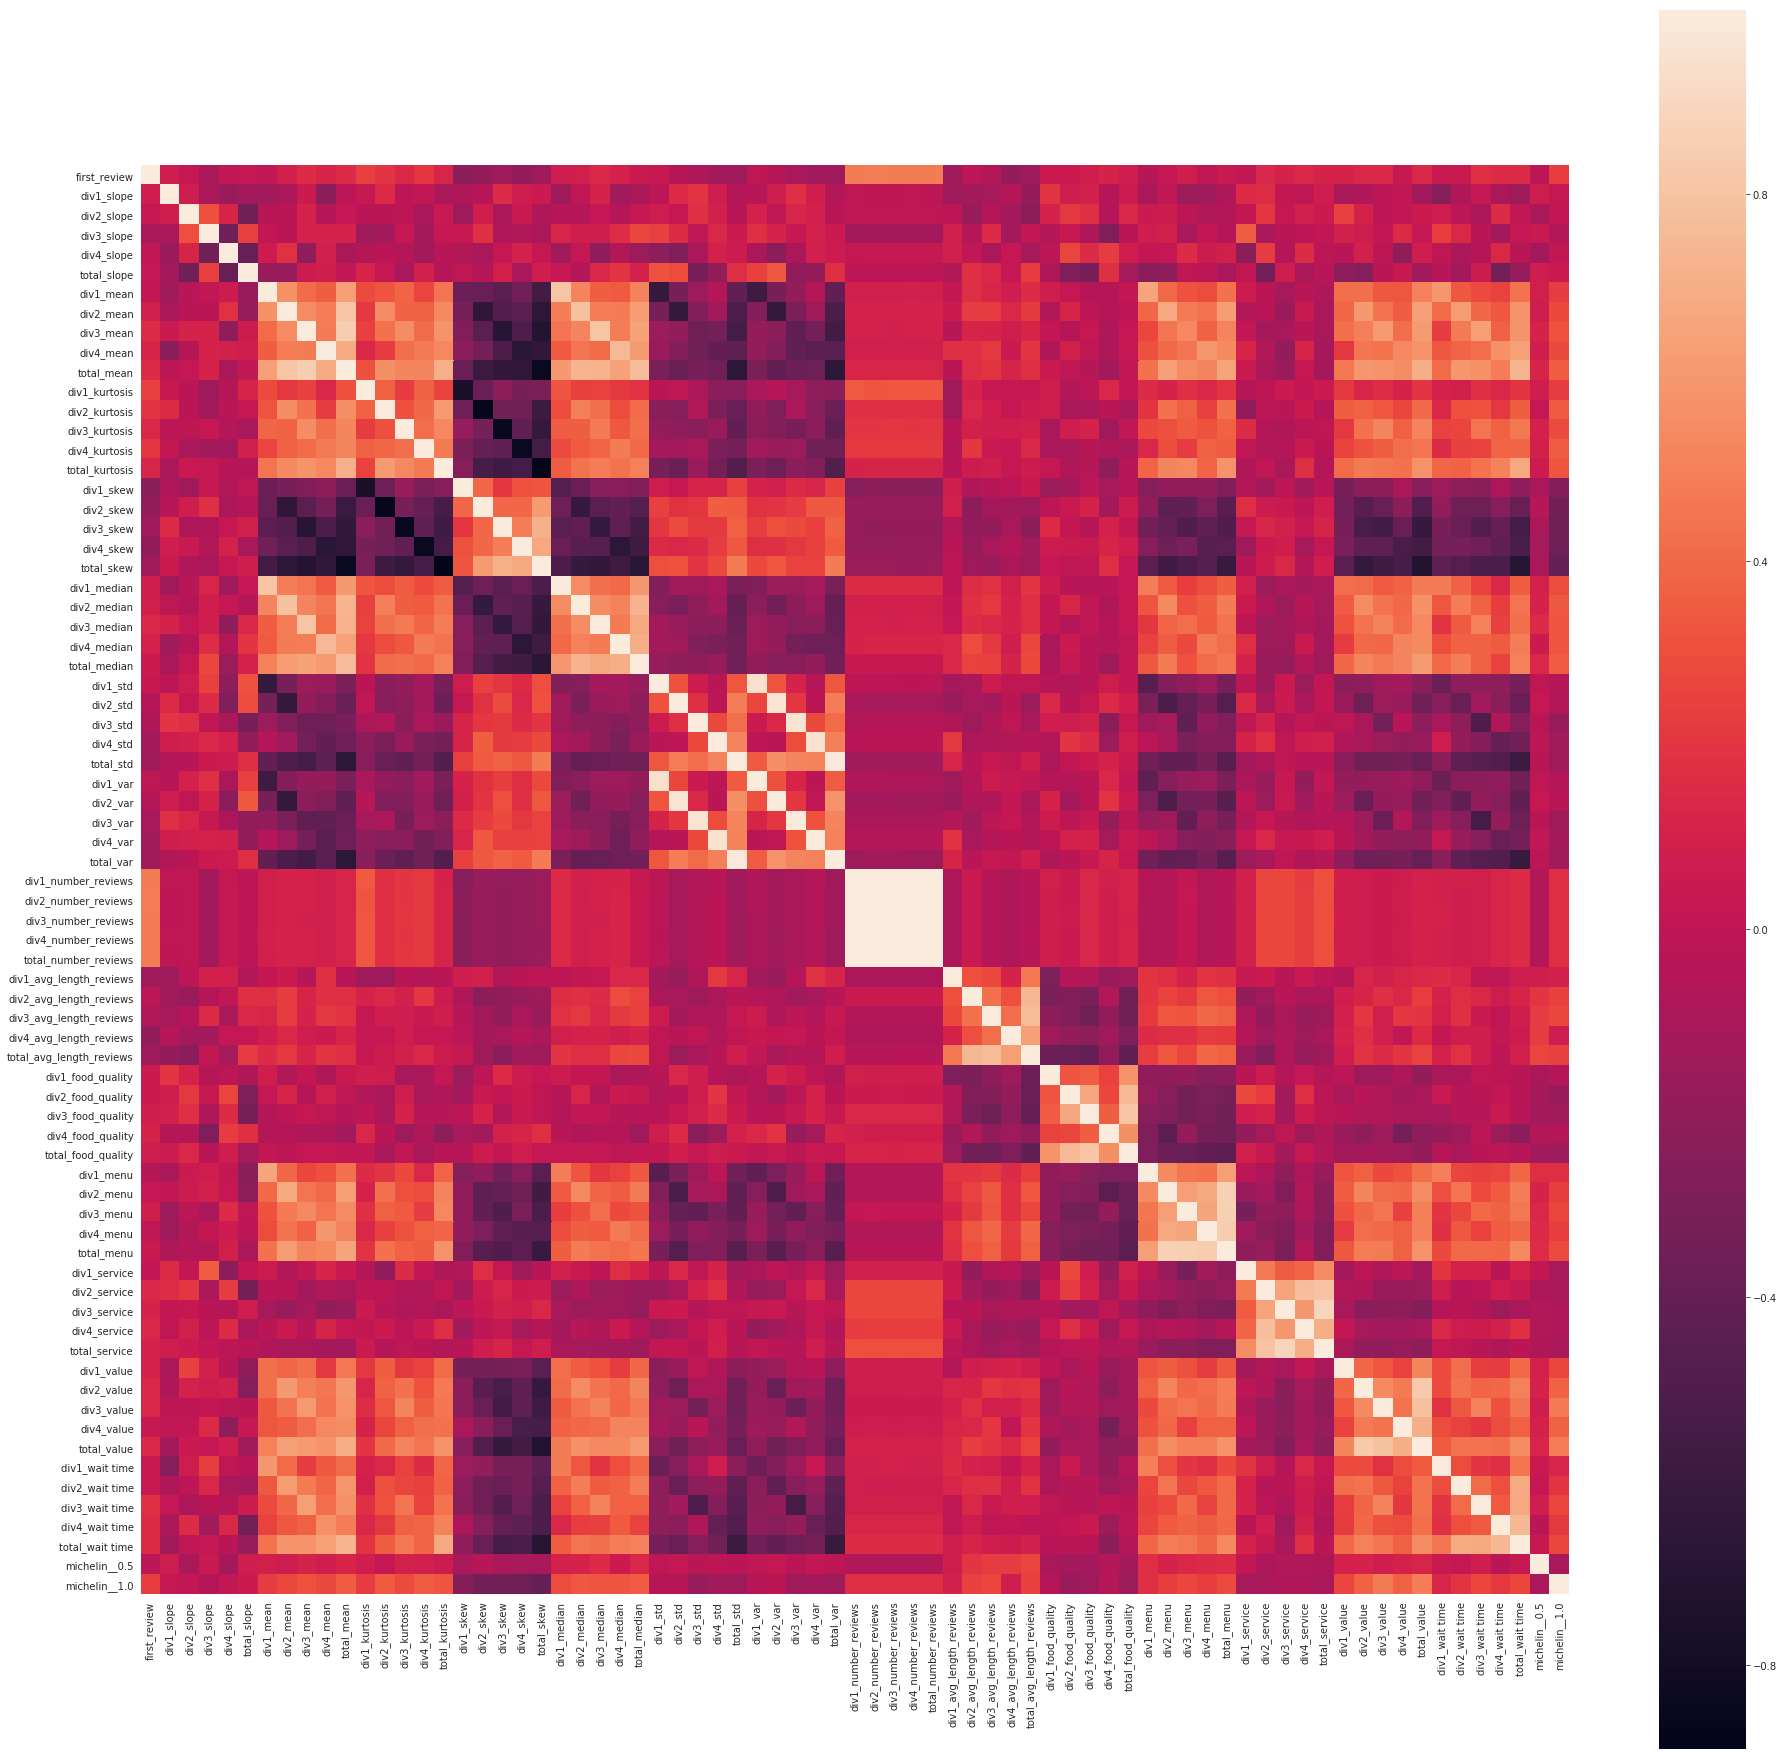

In [6]:
import seaborn as sns
plt.figure(figsize=(32, 32))
corr = train['X'].corr(method = 'pearson')
with sns.axes_style("white"):
    ax = sns.heatmap(corr, vmax=1, square=True)


## Get a baseline model with logsitc regression to evaluate Michelin survival in 2019

Mean Accuracy: 0.79
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        53
           1       0.00      0.00      0.00        14

    accuracy                           0.79        67
   macro avg       0.40      0.50      0.44        67
weighted avg       0.63      0.79      0.70        67

Confusion Matrix: 
 [[53  0]
 [14  0]]
0.7910447761194029


/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]

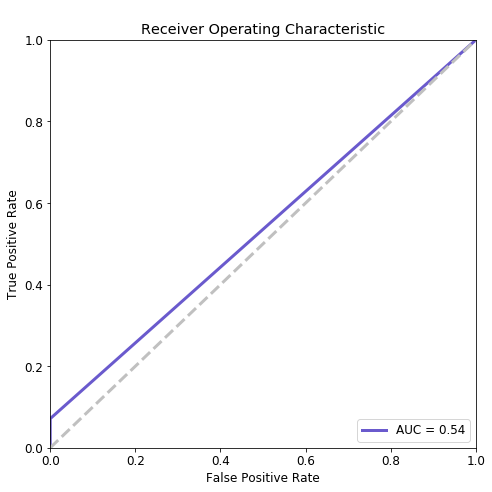

Cross validation score: 0.5870631401119206


In [7]:
clf = LogisticRegression()
clf = run_model(train, holdout, cols = train['X'].columns.values,  clf = clf)
score = cross_val_score(clf, train['X'], train['y'], cv = 10, scoring= 'roc_auc').mean()
print('Cross validation score: {}'.format(score))



## Resample to balanced classes using SMOTE

Mean Accuracy: 0.70
Classification Report: 
               precision    recall  f1-score   support

           0       0.69      0.74      0.71       414
           1       0.72      0.67      0.69       414

    accuracy                           0.70       828
   macro avg       0.70      0.70      0.70       828
weighted avg       0.70      0.70      0.70       828

Confusion Matrix: 
 [[305 109]
 [138 276]]
0.7016908212560387


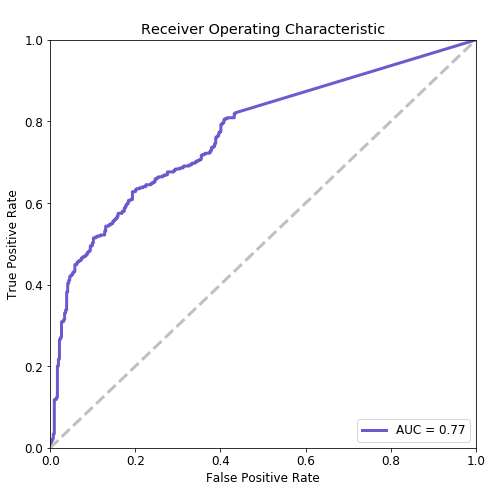

Cross validation score: 0.6784494503730503


In [8]:
resampled_train = {'X' : pd.DataFrame(), 'y': pd.Series()}
resampled_train['X'], resampled_train['y'] = make_resampled(train['X'], train['y'])

clf = LogisticRegression(C = 0.05)
clf = run_model(resampled_train, resampled_train, cols = resampled_train['X'].columns,  clf = clf, thresh = .45)

score = cross_val_score(clf, resampled_train['X'], resampled_train['y'], cv = 10, scoring= 'roc_auc').mean()
print('Cross validation score: {}'.format(score))


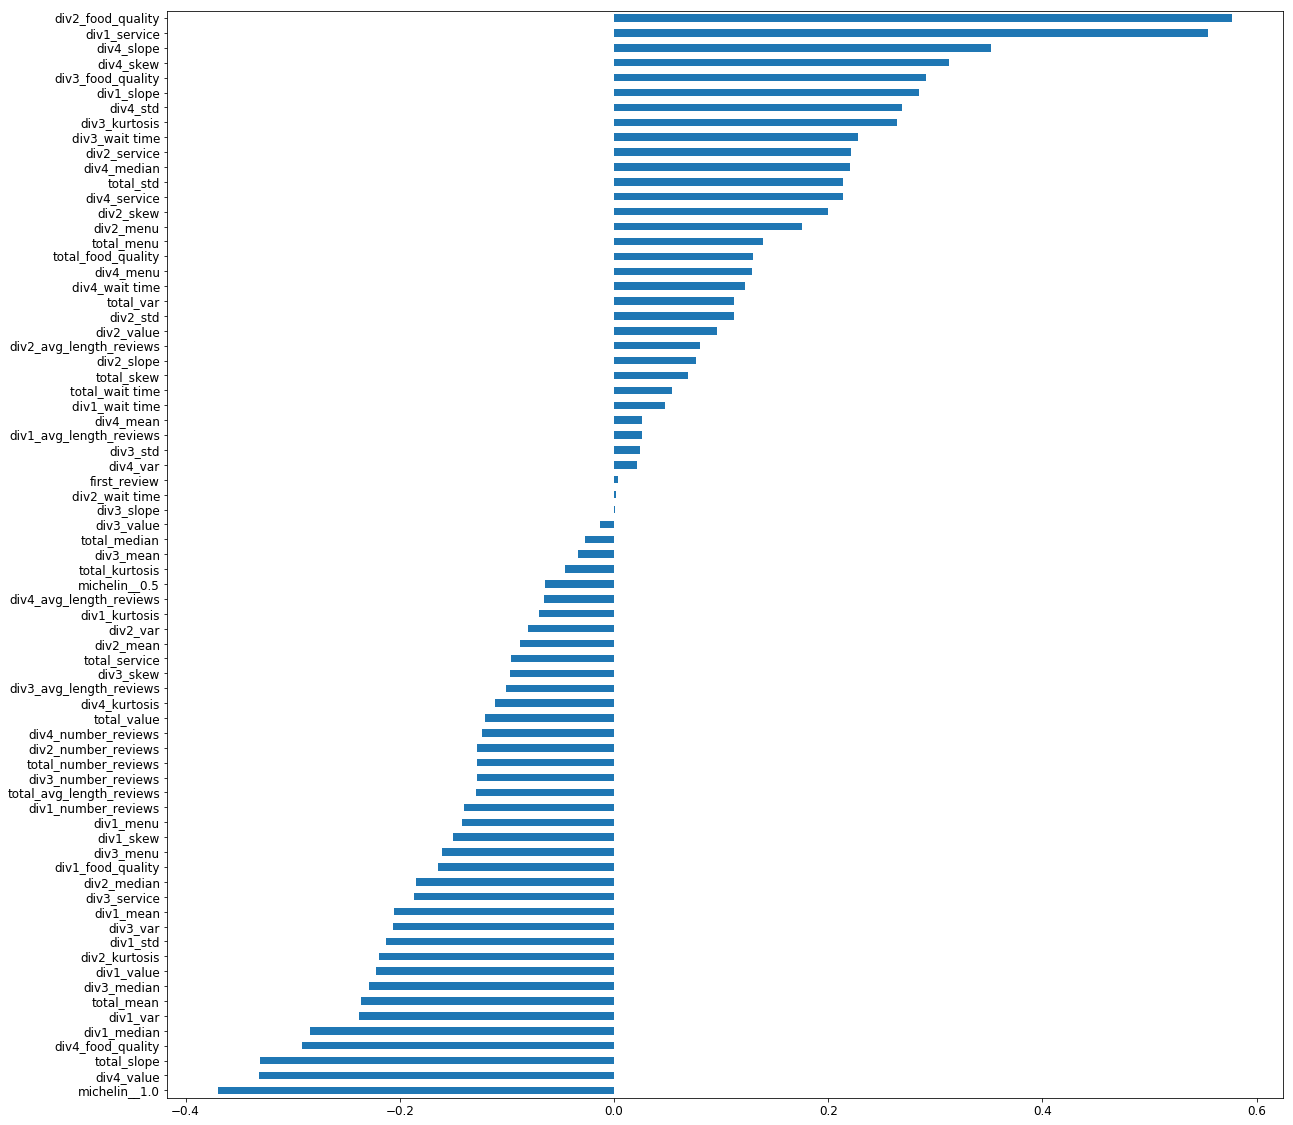

In [9]:
coefs_abs = pd.Series(clf.coef_[0], index = train['X'].columns).sort_values(ascending = True)
coefs_abs.plot.barh(figsize = (20,20))
plt.savefig('all_importance.png', transparent = False, dpi = 300)

## Evaluate model on holdout set

Mean Accuracy: 0.72
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.74      0.80        53
           1       0.39      0.64      0.49        14

    accuracy                           0.72        67
   macro avg       0.64      0.69      0.65        67
weighted avg       0.78      0.72      0.74        67

Confusion Matrix: 
 [[39 14]
 [ 5  9]]
0.7164179104477612


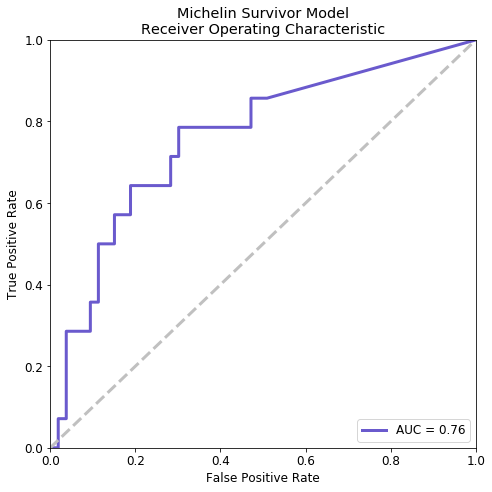

In [10]:
clf = LogisticRegression(C = .05)
clf = run_model(resampled_train, holdout, cols = resampled_train['X'].columns, thresh = .45,  clf = clf, title = 'Michelin Survivor Model')


## Feature elimination

Optimal number of features :35


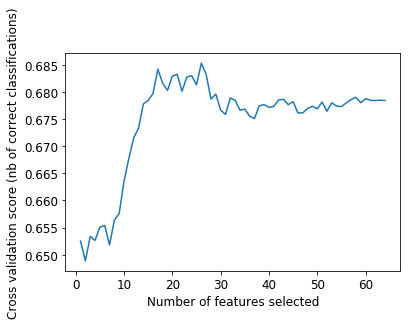

Mean Accuracy: 0.67
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.68      0.77        53
           1       0.35      0.64      0.45        14

    accuracy                           0.67        67
   macro avg       0.61      0.66      0.61        67
weighted avg       0.77      0.67      0.70        67

Confusion Matrix: 
 [[36 17]
 [ 5  9]]
0.6716417910447762


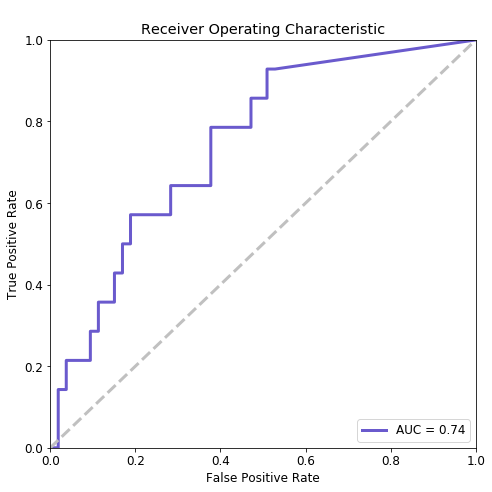

In [11]:
clf           = LogisticRegression(C = .05)
selected_cols = get_rfecv_features(resampled_train, clf = clf)
clf = run_model(resampled_train, holdout,  clf = clf, cols = selected_cols)

## Explore just rating data

Mean Accuracy: 0.81
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        53
           1       1.00      0.07      0.13        14

    accuracy                           0.81        67
   macro avg       0.90      0.54      0.51        67
weighted avg       0.84      0.81      0.73        67

Confusion Matrix: 
 [[53  0]
 [13  1]]
0.8059701492537313


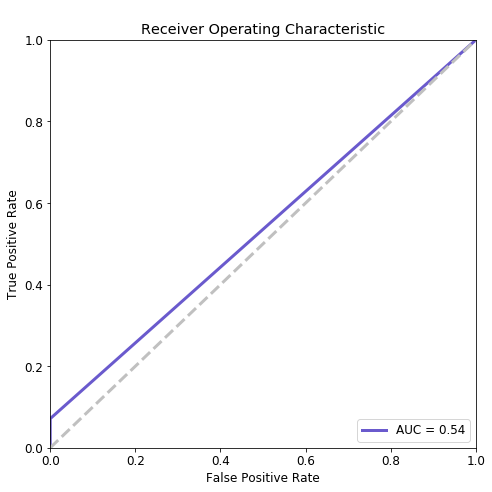

Mean Accuracy: 0.61
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.55      0.69        53
           1       0.33      0.86      0.48        14

    accuracy                           0.61        67
   macro avg       0.63      0.70      0.59        67
weighted avg       0.81      0.61      0.65        67

Confusion Matrix: 
 [[29 24]
 [ 2 12]]
0.6119402985074627


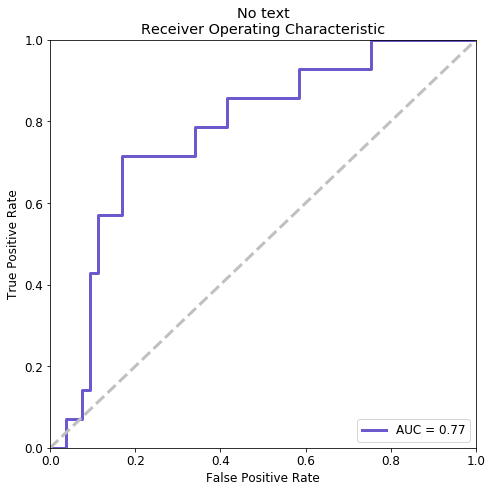

Cross validation score: 0.6471947712259601


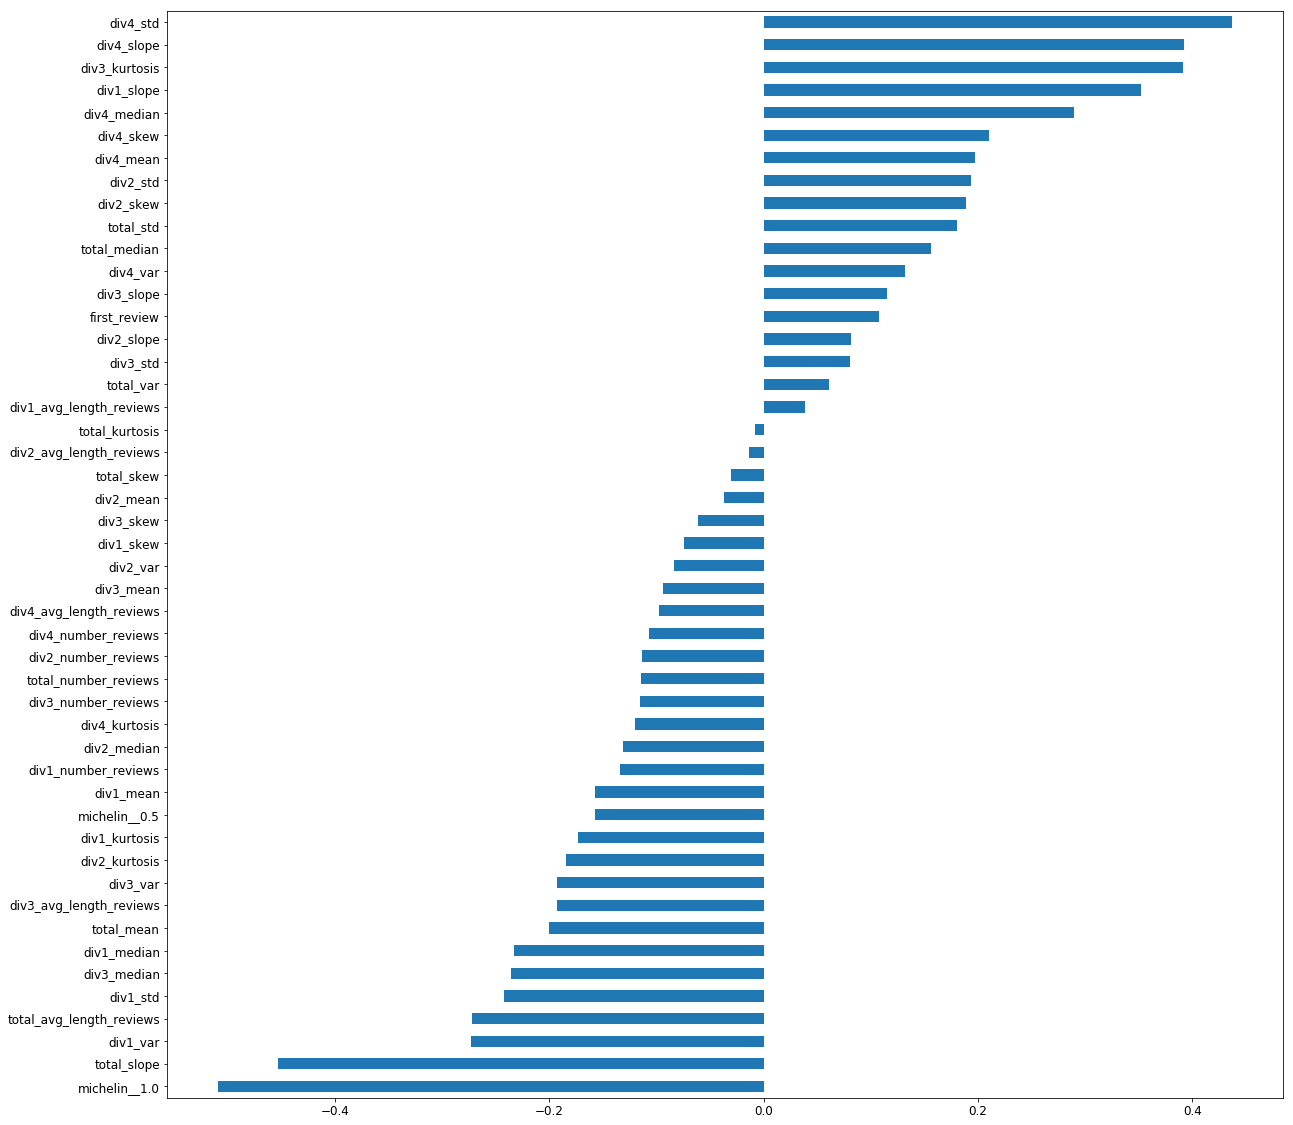

In [12]:
my_cols = list()
topics = ['food_quality', 'wait time', 'service', 'value', 'menu']
for each in train['X'].columns:
    for topic in topics:
        if topic in each:
            my_cols.append(each)
no_text = dict()            
no_text['X'] = train['X'].drop(my_cols, axis = 1)
no_text['y'] = train['y'].copy()

run_model(no_text, holdout, cols = no_text['X'].columns)

resampled_train = {'X' : pd.DataFrame(), 'y': pd.Series()}
resampled_train['X'], resampled_train['y'] = make_resampled(no_text['X'],no_text['y'])

clf = LogisticRegression(C = .05)
clf = run_model(resampled_train, holdout, cols = resampled_train['X'].columns,  clf = clf, title ='No text')
coefs_abs = pd.Series(clf.coef_[0], index = resampled_train['X'].columns).sort_values(ascending = True)
coefs_abs.plot.barh(figsize = (20,20))
plt.savefig('rating_importance.png', transparent = True, dpi = 300)

score = cross_val_score(clf, resampled_train['X'], resampled_train['y'], cv = 10, scoring= 'roc_auc').mean()
print('Cross validation score: {}'.format(score))



## Explore only text data

Mean Accuracy: 0.78
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.98      0.87        53
           1       0.00      0.00      0.00        14

    accuracy                           0.78        67
   macro avg       0.39      0.49      0.44        67
weighted avg       0.62      0.78      0.69        67

Confusion Matrix: 
 [[52  1]
 [14  0]]
0.7761194029850746


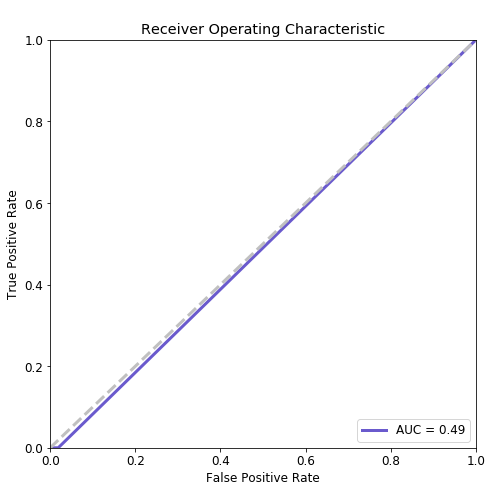

Mean Accuracy: 0.73
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.83      0.83        53
           1       0.36      0.36      0.36        14

    accuracy                           0.73        67
   macro avg       0.59      0.59      0.59        67
weighted avg       0.73      0.73      0.73        67

Confusion Matrix: 
 [[44  9]
 [ 9  5]]
0.7313432835820896


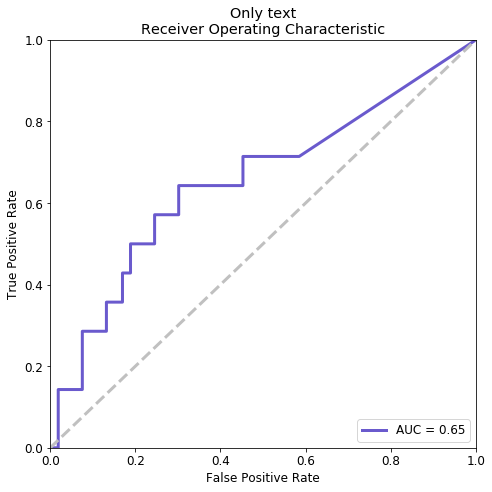

Cross validation score: 0.657406744176949


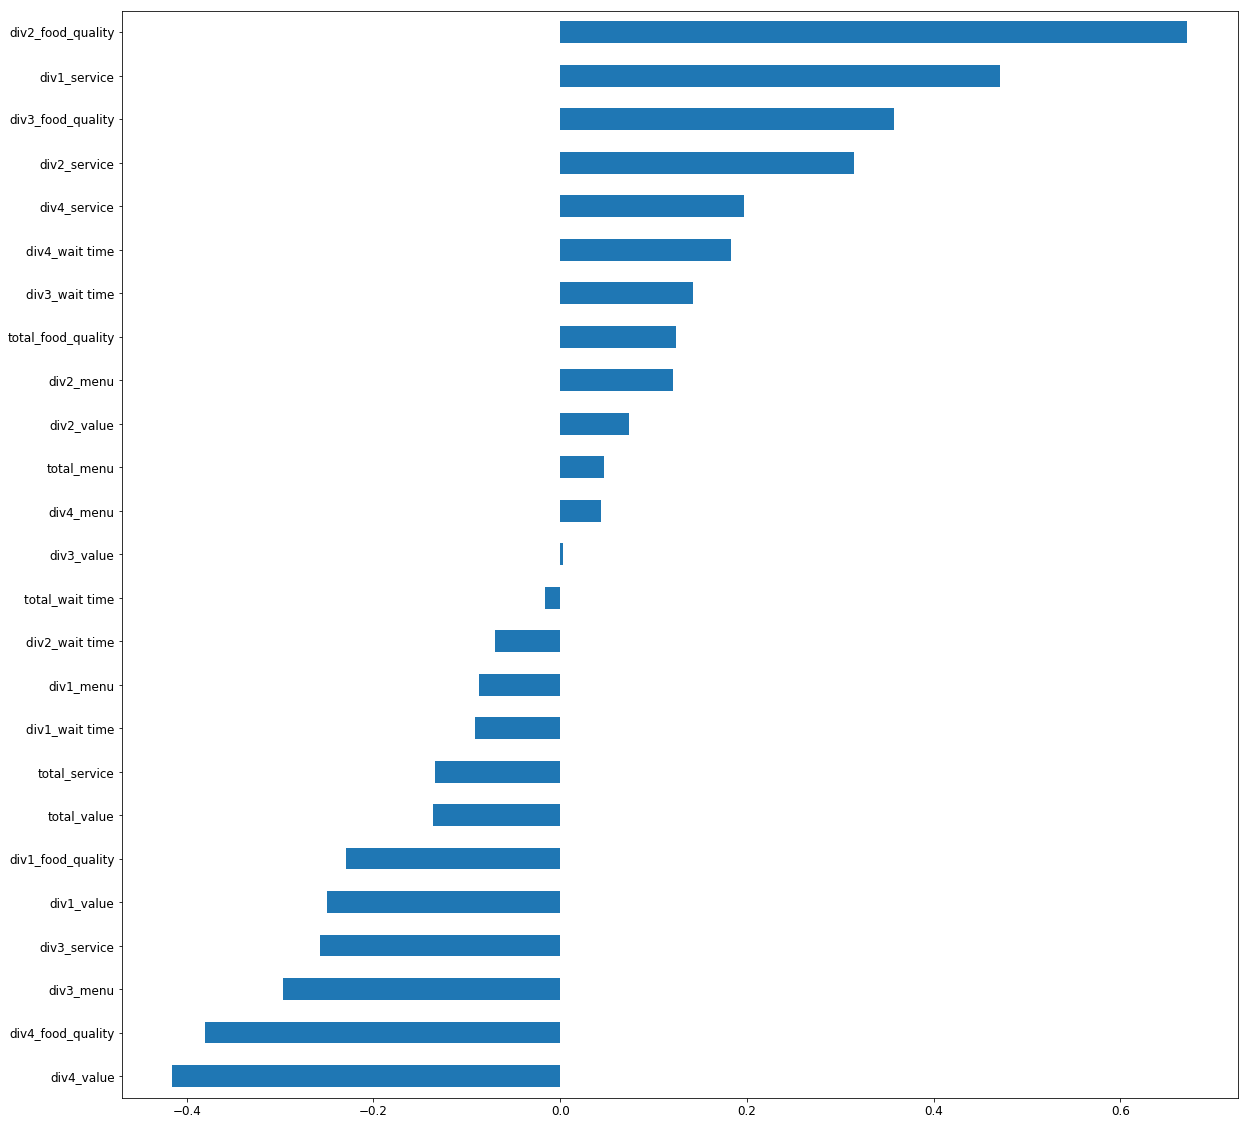

In [13]:
text = dict()            
text['X'] = train['X'][my_cols]
text['y'] = train['y'].copy()

run_model(text, holdout, cols = text['X'].columns)

resampled_train = {'X' : pd.DataFrame(), 'y': pd.Series()}
resampled_train['X'], resampled_train['y'] = make_resampled(text['X'],text['y'])

clf = LogisticRegression(C = .05)
clf = run_model(resampled_train, holdout, cols = resampled_train['X'].columns,  clf = clf, title = 'Only text')
coefs_abs = pd.Series(clf.coef_[0], index = resampled_train['X'].columns).sort_values(ascending = True)
coefs_abs.plot.barh(figsize = (20,20))
plt.savefig('text_importance.png', transparent = True, dpi = 300)


score = cross_val_score(clf, resampled_train['X'], resampled_train['y'], cv = 10, scoring= 'roc_auc').mean()
print('Cross validation score: {}'.format(score))


## Evaluate insights for at-risk restaurants for each year

Outputs csv for web-app

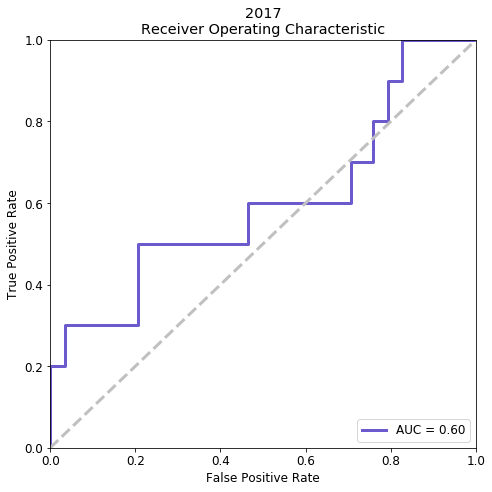

In [37]:
from sklearn.preprocessing import minmax_scale
predict_years   = [2017]

def produce_results(predict_year, michelin_data, yelp_data, thresh = .5):
    train, holdout = get_train_and_holdout(predict_year, michelin_data, yelp_data)
    df = holdout['X'].copy()
    resampled_train = {'X' : pd.DataFrame(), 'y': pd.Series()}
    resampled_train['X'], resampled_train['y'] = make_resampled(train['X'], train['y'])

    clf  = LogisticRegression(C = .05, random_state=0)
    clf.fit(resampled_train['X'], resampled_train['y'])

    probs = clf.predict_proba(holdout['X'])[:,1]
    
    thresh_probs = probs
#     thresh_probs[thresh_probs < thresh] = 0

    if predict_year != 2020:
        plot_roc(thresh_probs, holdout['y'], title = str(predict_year))
    
    at_risk = thresh_probs
    at_risk[at_risk > thresh] = 1
    at_risk[at_risk < thresh] = 0
    
    probs_pct = minmax_scale(probs, feature_range = (0, .99))
    probs_pct = pd.Series(probs_pct, index = holdout['X'].index)
    
    
    like             = 1 - minmax_scale(clf.predict_proba(holdout['X'])[:,1], feature_range=(.01,.99) )
    df['security']   = like
    like[like>.5]    = 0
    like[like!=0]    = 1
    
    df['at_risk']    = like
    df['actual']     = holdout['y']
    
    
    return df

data_dict = dict()
for predict_year in predict_years:
    data_dict[predict_year] = produce_results(predict_year, michelin_data, yelp_data)
    data_dict[predict_year].to_csv('michelin_{}_model_data.csv'.format(str(predict_year)))
    

# main_points = ['total_median', 'total_slope','div4_food_quality', 'div4_menu',  'div4_service', 'div4_value']

In [15]:
plot_roc( data_dict[2019].actual, data_dict[2019].at_risk)

KeyError: 2019

In [38]:
data_dict[2017]['security'].loc['the-spotted-pig']

0.3715069974406251